# Assignment
- Continue to predict New York City apartment rents. This is your last assignment with this dataset.
- You may select any number of features. You are encouraged to engineer new features.
- Get and plot your model's coefficients.
- Report your Root Mean Squared Error, Mean Absolute Error, and R^2 Score, for your Train and Test sets. Share your scores with your cohort on Slack!
- Fit a model with 2 features, and visualize the plane of best fit in 3D.
- Commit your notebook to your fork of the repo.

In [220]:
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as lr
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2, mean_squared_error as msq

In [207]:
LOCAL = '../data/nyc/nyc-rent-2016.csv'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/nyc/nyc-rent-2016.csv'

df = pd.read_csv(WEB)
assert df.shape == (48300, 34)
target = 'price'
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'exclusive', 'terrace', 'loft',
       'garden_patio', 'common_outdoor_space', 'wheelchair_access'],
      dtype='object')

**Basic Wrangle:**

Will create a column feature_is_missing for any column with any NaN values.

Will replace all NaNs in numeric columns with the mean

Will replace all NaNs in non-numeric columns with ''

In [208]:
def basic_wrangle(df):
    df = df.copy()
    
    #Create an is_missing column for every column with any NANs
    for col in df.columns:
        if df[col].isna().sum():
            df[f'{col}_missing'] = df[col].isna().astype(int)
            
    #Fill numeric columns with mean
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].fillna(value=df[col].mean)
    
    #Fill non-numeric columns with 'MISSING'
    for col in df.select_dtypes(exclude='number').columns:
        df[col] = df[col].fillna(value='')
    return df
df = basic_wrangle(df)

**Feature Enginerring:**

description_length is the length of the description feature

In [209]:
df['description_length'] = df['description'].apply(len)

In [210]:
df['dt'] = pd.to_datetime(df['created'])
df['month'] = df['dt'].dt.month
df = df.drop(columns='dt')

**Feature Encoding:**

One-Hot Encode interest level

In [211]:
interest_level_OHE = pd.get_dummies(df['interest_level'], prefix='interest_level')
interest_level_OHE
df = pd.concat([df,interest_level_OHE],axis=1)
df = df.drop(columns=['interest_level'])

**Feature Selection:**

Check the correlations between features in order to drop redundant ones

Drop high cordinality non-numeric features

Have two sets of features, one includes display_address, the other does not. Will test both sets.

In [212]:
df.describe(exclude='number')

,created,description,display_address,street_address
count,48300,48300,48300,48300
unique,47643,37491,8692,15094
top,2016-06-11 01:20:36,,Broadway,3333 Broadway
freq,3,1614,424,174


In [213]:
threshold = .9
corr = df.corr()
corr = corr[corr > threshold].fillna(value=0)
for col in corr.columns:
    if (len(corr[col].unique()) > 2): 
        print(f'{col}')

cats_allowed
dogs_allowed


In [214]:
dropped = ['cats_allowed', 'description', 'created', 'street_address', target]
dropped_2 = dropped + ['display_address']

features = df.drop(columns=dropped).columns
features_2= df.drop(columns=dropped_2).columns

**Train/Test Split**

In [215]:
test = df[df['month'].isin([6])].copy()
train = df[df['month'].isin([4, 5])].copy()
assert test.shape[0] + train.shape[0] == df.shape[0]

**Pre-Processing**

In [216]:
def pre_processing(train, test):
    pipeline = make_pipeline(ce.OrdinalEncoder())
    pipeline.fit(train)
    
    x_train = pd.DataFrame(pipeline.transform(train))
    x_train.columns = train.columns
   
    x_test = pd.DataFrame(pipeline.transform(test))
    x_test.columns = test.columns
    
    return x_train, x_test
pp_train, pp_test = pre_processing(train, test)

**Modeling:**

Using features

In [217]:
x_test = pp_test[features]
y_test = test[target]
x_train = pp_train[features]
y_train = train[target]

model = lr()
model.fit(x_train, y_train)
pred_test = model.predict(x_test)
mae(pred_test, y_test)

600.5056203129054

Using features_2

In [218]:
x_test2 = pp_test[features_2]
y_test2 = test[target]
x_train2 = pp_train[features_2]
y_train2 = train[target]

model2 = lr()
model2.fit(x_train2, y_train2)
pred_test2 = model2.predict(x_test2)
mae(pred_test2, y_test2)

599.0726861885735

**Model Coefficients**

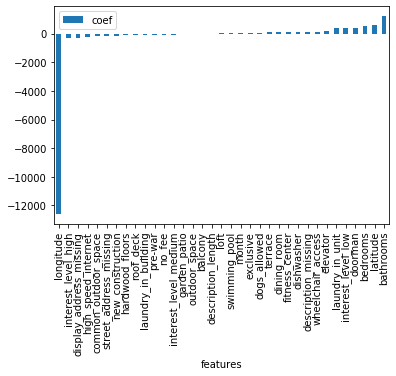

In [219]:
feature_importance = pd.DataFrame({'features':x_train2.columns, 'coef':model2.coef_})
feature_importance.index = feature_importance['features']
f_im = feature_importance.sort_values(by=['coef']).drop(columns='features')
f_im.plot.bar()

**Model Error**

In [223]:
def rmsq(pred, y):
    return np.sqrt(msq(pred, y))

In [228]:
{'r2': r2(pred_test2, y_test2), 'mae': mae(pred_test2, y_test2), 'rmsq': rmsq(pred_test2, y_test2)}

{'r2': 0.4341191540193743, 'mae': 599.0726861885735, 'rmsq': 843.427288064562}

**2 Features, plane of best fit**

In [232]:
features = ['longitude', 'bathrooms']

x_test = pp_test[features]
y_test = test[target]
x_train = pp_train[features]
y_train = train[target]

model = lr()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [236]:
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def viz3D(fitted_model, X, features, target='', num=100):
    """
    Visualize model predictions in 3D, for regression model fit on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 features
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://plot.ly/python/3d-charts/
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(min2, max2, num)
    combos = list(itertools.product(x1, x2))
    Z = fitted_model.predict(combos).reshape(num, num)

    data = [go.Surface(x=x1, y=x2, z=Z)]
    layout = go.Layout(
        scene={'xaxis': {'title': feature1, 'range': [min1,max1], 'showticklabels': True}, 
               'yaxis': {'title': feature2, 'range': [min2,max2], 'showticklabels': True}, 
               'zaxis': {'title': target, 'showticklabels': True}}, 
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
viz3D(model, pp_train, features, target)